## Industry Accelerators - Utilities Demand Response (DR) Program Propensity

## Introduction

In this notebook we will go through the end-to-end process of importing raw data, preparing the data, testing machine learning models, selecting the best performing model and deploying a pipeline. The model predicts how likely a customer is to enroll in the Demand Response Program. The models are built based on customer demographic, retail details and historical energy usage. We will use sklearn transformers to prepare the data, test different types of machine learning models, select the top performing model, combine it all in a final pipeline, before deploying the pipeline using Watson Machine Learning.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In the cell below we import the python libraries that we will use throughout the notebook.

We also install the eli5 package. We use this package later in the notebook for explaining the final model output.

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import os
import datetime

from IPython.display import Markdown, display

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

!pip install eli5
import eli5

from project_lib import Project
project = Project()

     |████████████████████████████████| 105 kB 814 kB/s eta 0:00:01


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Functions

The following cell contains a function which is used to generate a number of plots which are used for some preliminary analysis. The first chart shows the distribution of the variable passed to the function. If the variable is numerical, a second plot is generated which shows the variable bucketed up. The last plot shows the percentage of enrolled customers within each bucket for numerical variables or within each category for categorical variables. This gives the data scientist an idea of what single variables can impact the likelihood to a customer enrolling in the Demand Response Program. The function is called later in the notebook.

In [2]:
def plot_distribution_and_target_density(df, col_name, chart_type, target_col):
    if chart_type == 'numerical':
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 14))
        plt.subplots_adjust(hspace = 0.4)
        ax1.set_title('Variable Distribution - ' + col_name)
        dist_plt = sns.distplot(df[col_name], kde=False, ax=ax1)   
        # bin the numerical data
        # if there are less than 10 unique numbers, just split into the number of unique numbers
        if len(df[col_name].unique()) < 10:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], len(df[col_name].unique())-1)
        else:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], 10)
        col_name = col_name + '_BINNED'
        

    elif chart_type == 'categorical':
        fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(14, 10))
        plt.subplots_adjust(hspace = 0.4)

    df_var_summary = df.groupby(col_name)[target_col].agg(['count', 'mean']).reset_index()
    df_var_summary.rename(columns={'count':'Number of Records', 'mean':'Target Density'}, inplace=True)
    
    # if we are using a binned variable sort binning lowest to highest
    # we can also drop it from the raw data now
    # if categorical, sort by the number of records
    if chart_type == 'numerical': 
        df_var_summary.sort_values(col_name, inplace=True)
        df.drop(col_name, axis=1, inplace=True)
    elif chart_type == 'categorical':
        df_var_summary.sort_values('Number of Records', inplace=True, ascending=False)

    ax2.set_title('Number of Records per Category - ' + col_name)

    category_plt = sns.barplot(x=col_name,y='Number of Records',data=df_var_summary, color="skyblue", ax=ax2)
    category_plt = category_plt.set_xticklabels(category_plt.get_xticklabels(), rotation=30, horizontalalignment='right')
    category_plt = ax2.set_xlabel('')

    target_density_plot = sns.barplot(x=col_name, y='Target Density', data=df_var_summary, color="skyblue", ax=ax3)

    ax3.set_title('Target Density per Category - ' + col_name)

    for patch in ax3.patches:
        bar_height = patch.get_height()
        ax3.text(patch.get_x()+patch.get_width()/2.,
                bar_height/2,
                np.round(bar_height, 2),
                ha='center', color='white', weight='bold', fontsize=10) 

    target_density_plot.axhline(y=df[target_col].mean(), ls='--')
    target_density_plot.text(1, df[target_col].mean() + 0.01, 'Average Target Density :' + str(np.round(df[target_col].mean(), 2)), fontsize=10, va='center', ha='center')
    target_density_plot = target_density_plot.set_xticklabels(target_density_plot.get_xticklabels(), rotation=30, horizontalalignment='right')
    target_density_plot = ax3.set_xlabel('')
    
    return

## Load Demand Response Propensity Data

We provide a dataset with demographical and behavioural attributes for our customers. Each customer has one record in the dataset and is stamped with whether the customer enrolled in the Demand Response Program or not. The SQL query to create the dataset is included in the project. The cells below import the data and display a sample of the raw data.

In [3]:
my_file = project.get_file('Demand Response View.csv')
my_file.seek(0)
df_prep = pd.read_csv(my_file, low_memory=False)

In [4]:
df_prep.head()

,CUSTOMER_ID,FIRST_NAME,LAST_NAME,PHONE_1,EMAIL,AGE,HOME_SIZE,ENERGY_USAGE_PER_MONTH,ENERGY_EFFICIENCY,IS_REGISTERED_FOR_ALERTS,...,EMPLOYMENT,SEGMENT,STD_YRLY_USAGE_CUR_YEAR_MINUS_1,STD_YRLY_USAGE_CUR_YEAR_MINUS_2,STD_YRLY_USAGE_CUR_YEAR_MINUS_3,STD_YRLY_USAGE_CUR_YEAR_MINUS_4,STD_YRLY_USAGE_CUR_YEAR_MINUS_5,STD_YRLY_USAGE_CUR_YEAR_MINUS_6,STD_YRLY_USAGE_CUR_YEAR_MINUS_7,MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1
0,1,Leonor,Cummerata,781-757-3537,Leonor.Cummerata@nola.biz,44,1980,5080,0.390,1,...,Employed full-time,Green Advocate,56049,43703,26666,26666,28642,26666,22963,20500
1,2,Ima,Labadie,505-339-5197,Ima.Labadie@allie.tv,34,1770,4970,0.356,0,...,Employed full-time,High Flyers,52098,40740,26666,26666,26666,26666,21481,20500
2,3,Brycen,Hermiston,309-713-5431,Brycen.Hermiston@kristina.biz,39,5810,9250,0.628,1,...,Employed full-time,High Flyers,52098,40740,24691,24691,26666,24691,21481,20500
3,4,Nicolas,Baumbach,507-490-8532,Nicolas.Baumbach@amber.biz,37,1450,4330,0.335,1,...,Employed full-time,Budget Payment Plan Members,52098,40740,24691,24691,26666,24691,20000,20500
4,5,Deshawn,Ryan,409-899-6328,Deshawn.Ryan@kristoffer.us,54,3780,9190,0.411,1,...,Employed full-time,NaN,48148,37777,24691,24691,24691,24691,20000,20500


## Specify User Inputs

We specify the user inputs in the cell below.

**target_col :** This is the column name for our target variable.<br>
**l_numerical_features :** A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list. The flag like variables get programmatically separated from the numerical variables.<br>
**l_cat_cols :** A list of all categorical variables that need to be transformed before input into the model. We will use a transformer to impute missing values and create dummy variables.<br>
**l_cat_cols_for_grouping :** Some of our categorical variables have categories with very few values. We aggregate these categories up into one category called 'Other'.<br>
**cat_perc_cutoff :** Cutoff percentage for aggregating categories. For example, if 0.05 is specified, categories with less than 5% of cases will be aggregated into 'Other' category.<br>

If the data scientist is using their own data, they can easily update the variables below to point at their own specific dataset columns.

All of these variables are stored in a dictionary which is saved as part of the metadata when deploying the pipeline in the deployment space. We store this dictionary so that the same initial data preparation (grouping categories) is carried out when scoring new data.  

In [5]:
target_col = 'DEMAND_RESPONSE'

l_numerical_features = ['AGE',         
       'HOME_SIZE', 'ENERGY_USAGE_PER_MONTH',
       'ENERGY_EFFICIENCY', 'IS_REGISTERED_FOR_ALERTS', 'OWNS_HOME',
        'COMPLAINTS', 'CLTV', 
        'HAS_EV', 'HAS_PV', 'HAS_WIND',
        'EBILL','IN_WARRANTY', 'HAS_HOME_AUTOMATION', 'HAS_THERMOSTAT',
        'STD_YRLY_USAGE_CUR_YEAR_MINUS_1', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_2',   
        'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4',
        'STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 
        'STD_YRLY_USAGE_CUR_YEAR_MINUS_7', 'MEDIAN_YRLY_USAGE_CUR_YEAR_MINUS_1']

l_cat_cols = ['GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CITY', 'EMPLOYMENT', 'SMART_METER_COMMENTS', 'SEGMENT']

l_cat_cols_for_grouping= ['EDUCATION', 'EMPLOYMENT']

# specify the min % of cases where we will group up categories
cat_perc_cutoff = 0.05

The user includes flag like variables in the list of numerical inputs above. We programmatically remove these variables from the numeric variable list and put them in their own list, `l_bool_cols`. We do this by looping through each numeric column, if the column contains 2 unique values only and those values are 0 and 1, we add them to the boolean list.

In [6]:
# split the flag like variables out from the numeric variables
l_bool_cols = []
for col in l_numerical_features:
    col_vals = df_prep[col].dropna().unique()
    col_vals = np.sort(col_vals)
    # if there are only 2 values in the array, first is 0 and second is 1, then we know it's a boolean variable
    if len(col_vals) == 2 and col_vals[0] == 0 and col_vals[1] == 1:
        l_bool_cols.append(col)

# remove from the numeric variables
l_numerical_features = [col for col in l_numerical_features if col not in l_bool_cols]

### Display Target Distribution

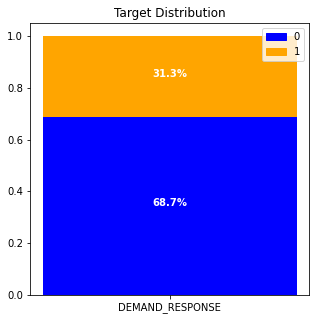

In [7]:
# start by having a look at the target variable
# plot the distribution of the target for each product
df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

orange_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, orange_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/2
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)


## Data Prep

### Aggregate Categorical Variables

We loop through the list of categorical variables that require aggregating. Any category in the column that makes up less than `cat_perc_cutoff` percentage of cases is aggregated into a new category called 'Other'.

Since we will need to do this aggregation every time we want to score new data, we save the aggregated category names out into a dictionary for future use. This dictionary will be combined with other metadata and saved as part of the final pipeline deployment. We can then access this metadata in our deployed function in the next notebook. Any new data to be scored will first be updated with the new category name if required, before being passed to the pipeline.  

In [8]:
# Some of our categorical variables have categories that have very few cases, we will group these up into a new category called 'other' 
grouping_dict = {}

for col in l_cat_cols_for_grouping:
    df_temp = df_prep[col].value_counts(dropna=False).reset_index()
    df_temp['%'] = np.round(df_temp[col] / df_temp[col].sum(), 2)
    df_temp.rename(columns={'index' : col, col : 'Number of Occurances'}, inplace=True)
    # update the categorical names for any category where % doesn't meet the specified threshold
    updated_categories_dict = { i : 'Other' for i in list(df_temp[df_temp['%']< cat_perc_cutoff][col])}
    df_prep[col].replace(updated_categories_dict, inplace=True)
    # keep a record of the grouping as we will need to apply it when scoring new data
    grouping_dict[col] = updated_categories_dict

### Correlation Analysis

We carry out a correlation analysis on all variables specified in `l_numerical_features`.

From the result of the analysis we can see that the historical yearly usage is highly correlated. This is most likely due to the nature of how this synthetic data was generated. We remove all but 1 of these variables from the numerical list. While they remain in our dataset they will be dropped from the transformer.

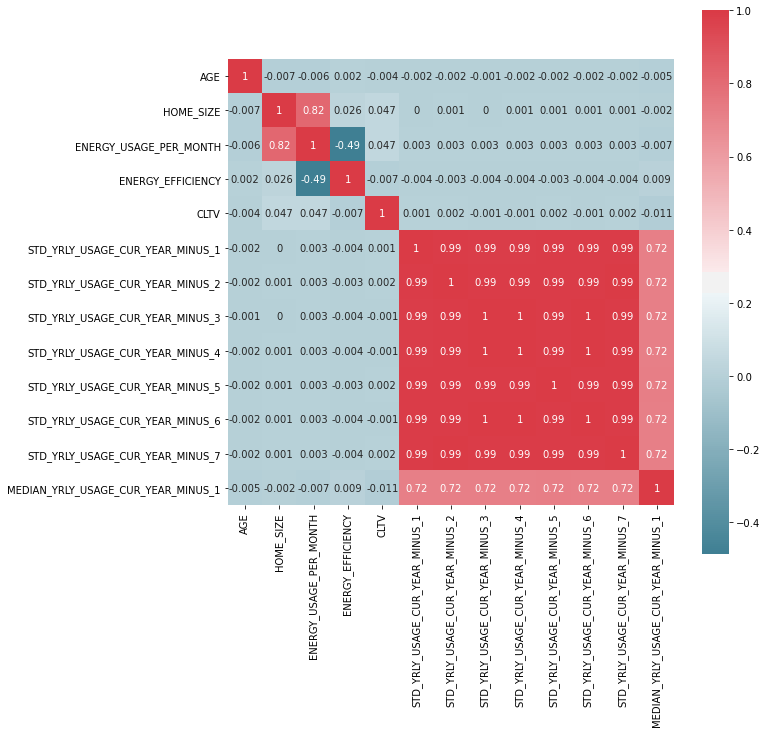

In [9]:
# check correlation between numerical features
f, ax = plt.subplots(figsize=(10, 10))
corr = df_prep[l_numerical_features].corr()
corr = corr.round(3)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

In [10]:
# the annual usage over the last 7 years is highly correlated - a result of the how the synthetic data was generated 
# we can remove all but 1 of these variables
l_numerical_cols_to_drop = ['STD_YRLY_USAGE_CUR_YEAR_MINUS_2', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_3', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_4','STD_YRLY_USAGE_CUR_YEAR_MINUS_5', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_6', 'STD_YRLY_USAGE_CUR_YEAR_MINUS_7']

# also remove them from the list of numerical features
l_numerical_features = [i for i in l_numerical_features if i not in l_numerical_cols_to_drop]

## Visualise the Input Data

As already described, we use the `plot_distribution_and_target_density`function to create plots for a selection of variables. The user specifies the column to be visualised and whether the column is numerical or categorical.

For numerical variables, 3 charts are displayed:
  1. Distribution of the numerical variable.
  2. Group the numerical data into 10 buckets of equal size. Display the number of cases in each bucket and the range of values in each.
  3. Display the percentage of customers in each bucket who enrolled in the program. 

The charts for categorical variables are very similar, but we don't need to bucket categorical variables. 2 charts are displayed:
  1. Distribution of the categorical variable. Displays the number of cases in each category of the variable.
  2. Display the percentage of customers in each bucket who enrolled in the program. 

We first plot **Marital Status**. This variable has 3 categories, S - Single, M - Married, U - Unknown. We see some variation in the target density plot. Customers who are married are more likely to enroll in the Demand Response Program.

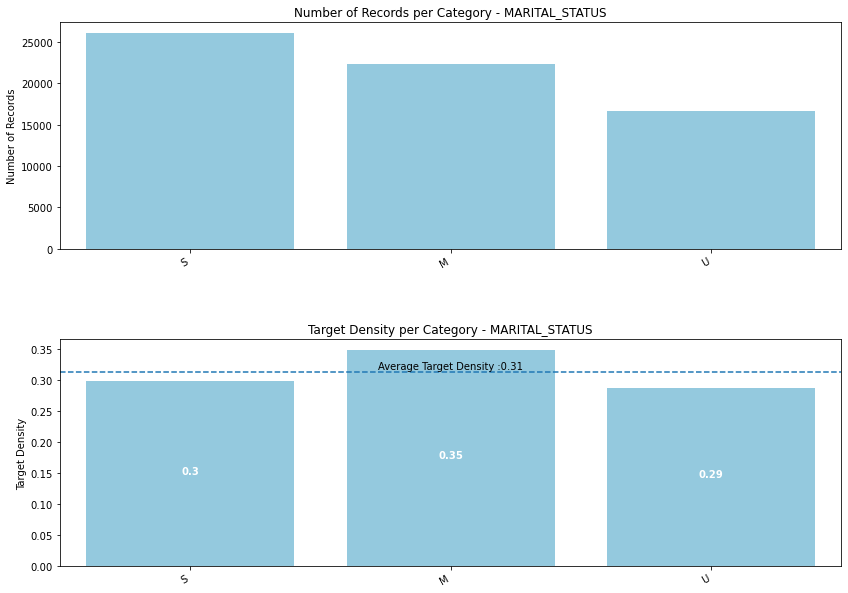

In [11]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'MARITAL_STATUS', chart_type, target_col)

Next we look at the **City** in which the customer is located. Customers in Mountain View and Sunnyvale are more likely to join the Program while those in Palo Alto and Cupertino are less likely.

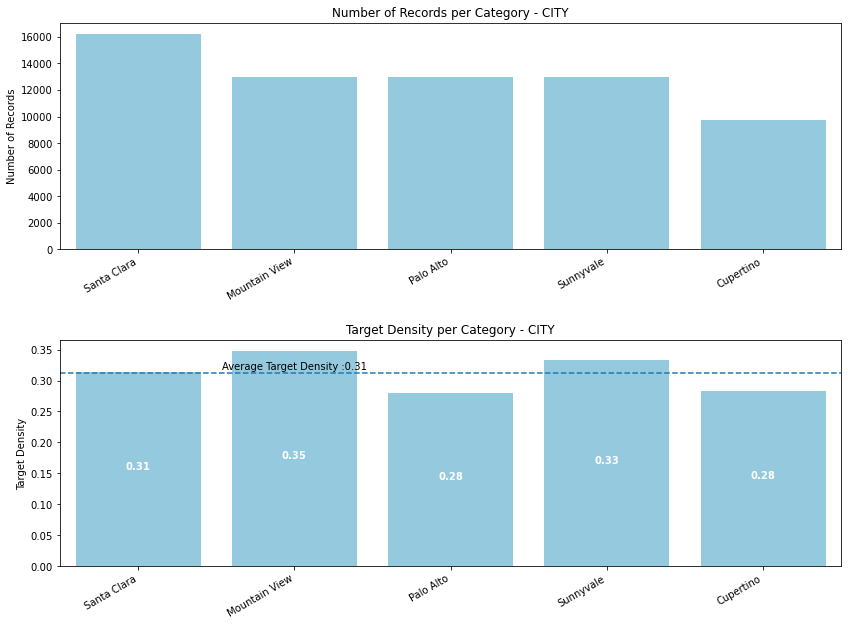

In [12]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'CITY', chart_type, target_col)

We see some variation in the **IS_REGISTERED_FOR_ALERTS** variable. 37% of customers who are registered joined the Demand Response Program while only 23% of customer who are not registered enrolled in the Program. 

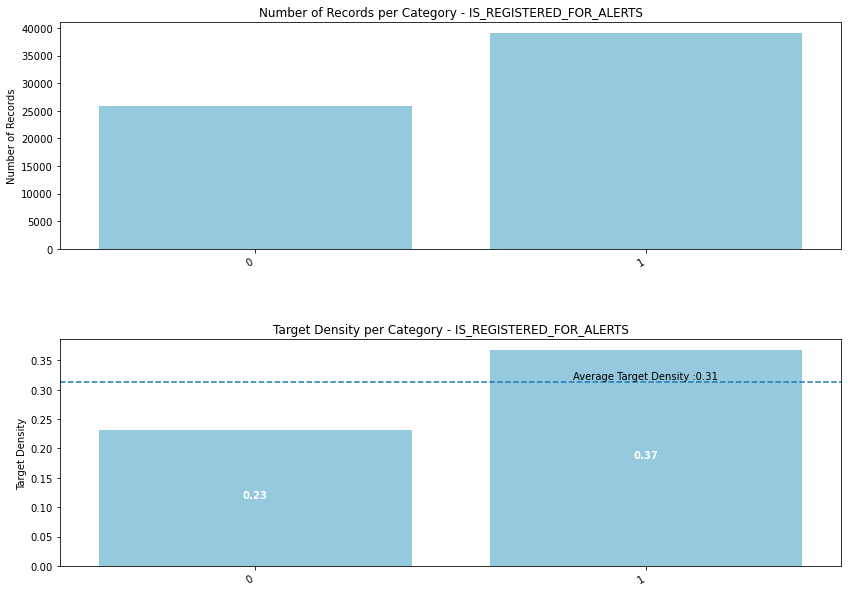

In [13]:
chart_type = 'categorical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'IS_REGISTERED_FOR_ALERTS', chart_type, target_col)

Taking an example of a numerical variable, we plot **Energy Efficiency**. The values for efficiency range from 0.3 to 0.83, with a slight skew, more customers have lower energy efficiency. Looking at the target density after bucketing the variable, we see quite a bit of variation. We have customers with low efficiency and also high efficiency who are more likely to enroll in the Program.

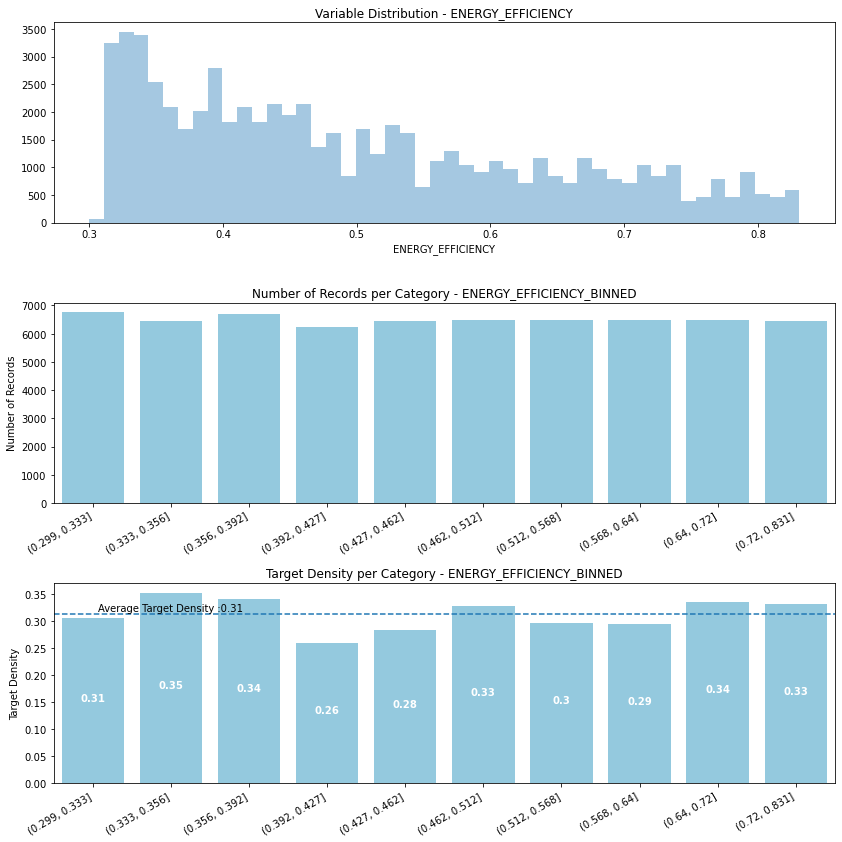

In [14]:
chart_type = 'numerical' # 'categorical' 'numerical'
plot_distribution_and_target_density(df_prep, 'ENERGY_EFFICIENCY', chart_type, target_col)

## Build Machine Learning Models

### Split Data and Build Transformer

We split the data into training and test sets. We use 70% of the data for training and the remaining 30% for testing. We do cross validation, build different machine learning models and carry out hyperparameter tuning on the training dataset. 

We use built-in sklearn transformers to process the data and get it ready for input into the model.

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer` transformer to fill in missing values with 'Other'. Next we use `OneHotEncoder` to create dummy variables for each category. The transformers are applied to the features specified in the `l_cat_cols` variable.

For numerical variables we create 2 different pipelines. The specific pipeline to be used is determined based on the model type being built. For our tree based models, we create the pipeline called `numeric_transformer` which uses the `SimpleInputer` transformer to fill in missing values. The second numeric pipeline also carries out this step but also includes the additional step of standardising the numeric variables using `StandardScaler`. This is required for the penalised logistic regression models which we build. The transformers are applied to the features specified in `l_numerical_features` variable.

For boolean variables, we use `SimpleImputer` to fill in missing values. We fill the missing values with the median to ensure that the filled value is either 0 or 1.

In [15]:
X = df_prep.drop([target_col], axis=1)
y = df_prep[target_col]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=123)

In [17]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='mean'))])
# if we are using penalised logistic regression we need to scale our numeric variables, it's not required for the tree based models we're using 
lr_numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='mean')), ('standardise_vars', StandardScaler())])
# to maintain the 0, 1 values in the bool use median to replace missing values
bool_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, l_numerical_features),
        ('bool', bool_transformer, l_bool_cols),
        ('cat', categorical_transformer, l_cat_cols)
            ])

# create a different preprocessor for the Logistic regression model, only difference is this standardises the variables
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', lr_numeric_transformer, l_numerical_features),
        ('bool', bool_transformer, l_bool_cols),
        ('cat', categorical_transformer, l_cat_cols)
            ])

### Model Selection and Hyperparameter Tuning

In the cell below we use 2 dictionaries for model selection and hyperparameter tuning. The `models_dict` dictionary contains all models that we are going to build. The `params_dict` dictionary contains dictionaries with the hyperparameter selections we are going to use with each model. We loop through the dictionary with models, building a pipeline with transformer and the model. We apply the pipeline with cross validation for each hyperparameter selection. 

In this example we do 3 fold cross validation to limit the amount of time it take to run the notebook end to end. The data scientist can change this to as many folds as are required.

The output of the cells below is the best performing hyperparameter selection for each model type and finally which model performed best overall. The evaluation metric used in Area Under the Curve (AUC).

In [19]:
models_dict = {'LogisticRegression' : LogisticRegression(random_state=0, solver='liblinear'), 
               'RandomForestClassifier' : RandomForestClassifier(random_state=0, n_jobs=-1), 
               'xgBoost' : xgb.XGBClassifier(random_state=0)}

# to update the parameters in the model step of the pipeline, pass the step name as a key along with "__" after it
# for example, the model step is called "classifier", to change the n_estimators hyperparameters we have a key in the parameter dictionary called "classifier__n_estimators"
params_dict = {'LogisticRegression': {'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.01, 0.1, 1]},
                'RandomForestClassifier' : {'classifier__n_estimators': [50], 'classifier__max_depth' : [10, 15, 20], 'classifier__max_features' : [0.75, 0.9]},
                  'xgBoost' : {'classifier__n_estimators': [50], 'classifier__max_depth' : [3, 5, 7], 'classifier__learning_rate' : [0.01, 0.1]}}

In [20]:
top_auc_cv_training = 0.0
cross_validation = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

for key, model in models_dict.items():
    
    params = params_dict[key]
    
    # if using logistic regression use the pipeline that contains the standard scaler
    if key == 'LogisticRegression':
        pipeline = Pipeline(steps=[('preprocessor', lr_preprocessor),
                          ('classifier', model)])
    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])

    clf = GridSearchCV(pipeline, params, cv=cross_validation, scoring='roc_auc', return_train_score=True)
    clf.fit(X_train, y_train)

    # loop through the best hyperparameters and create a string so we can print them out nicely
    param_string = ' from '
    for param_key, param in clf.best_params_.items():
        hyper_param = param_key.replace('classifier__', '')
        new_string = hyper_param + ' of ' + str(param) + ', '
        param_string += new_string

    param_string = param_string[:-2]
    param_string

    print('Model - ' + key + ' : Cross Validated Training AUC : ' + str(np.round(clf.best_score_, 3)) + param_string)
    if clf.best_score_ > top_auc_cv_training:
        top_auc_cv_training = clf.best_score_
        top_pipeline = clf.best_estimator_
        top_model_name = key
        
display(Markdown('\n**Final Model - ' + top_model_name + '**'))

Model - LogisticRegression : Cross Validated Training AUC : 0.681 from C of 1, penalty of l1
Model - RandomForestClassifier : Cross Validated Training AUC : 0.897 from max_depth of 15, max_features of 0.9, n_estimators of 50
Model - xgBoost : Cross Validated Training AUC : 0.896 from learning_rate of 0.1, max_depth of 7, n_estimators of 50



**Final Model - RandomForestClassifier**

### Apply Final Pipeline to Unseen Test Data

The cell above saves pipeline with best performing model and hyperparameter selection. We apply this pipeline to the, as of yet, unseen, test data and return the AUC. We can see that the AUC for both the cross validation training data and unseen test data is very similar. 

In [21]:
y_pred_test = top_pipeline.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Final Model - ' + top_model_name + ' : Cross Validated Training AUC : ' + str(np.round(top_auc_cv_training, 3)) + ' and Test AUC : ' + str(np.round(auc_test, 3)))

Final Model - RandomForestClassifier : Cross Validated Training AUC : 0.897 and Test AUC : 0.898


### View Model Results

First we'll look at the plot of the ROC curve as we used the area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate (Sensitivity) and false positive rate (1-Specificity). Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

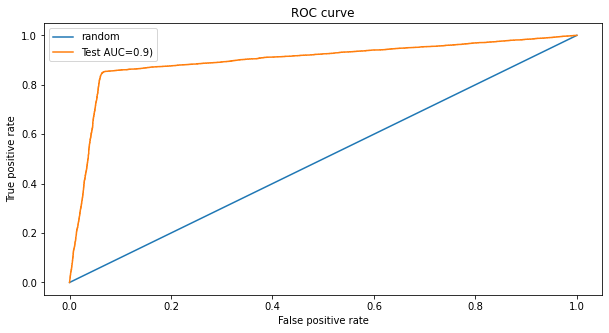

In [22]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

If the user would also like to assign a 1, 0 classification to each customer we can use the result from the ROC curve. Based on the test ROC curve result we select the optimum probability threshold value based on Youden's Index. Any probabilities greater than the selected threshold will be classed as 1, otherwise 0.

In [23]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_test - fpr_test)
opt_threshold = thresholds_test[idx_opt_thres]
print('Optimal Probability Threshold : ' + str(np.round(opt_threshold, 3)))

y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)

Optimal Probability Threshold : 0.38


We'll next look at the confusion matrix for the test results at the threshold selected above. At this threshold the classifier does a good job at correctly predicting those who enroll in the Program or not. 

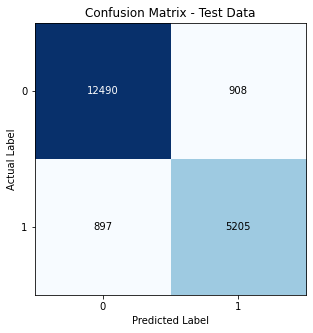

In [24]:
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.imshow(confusion_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix - Test Data')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_test, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax1.text(x, y, num_occurances, color="white" if confusion_matrix_test[x, y] > confusion_matrix_test.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

### Cumulative Gains and Lift Charts

Next we generate the cumulative gains chart generated from the data used for model training.

The cumulative gains chart shows the percentage of customers who enrolled in the Demand Response Program selected by targeting a specific percentage of total customers. The x-axis has the percentage of total customers used in model training and the y-axis has the percentage of customers who actually joined the program. Taking an example of targeting the first 30% of customers. If we were to select these customers randomly, we would expect the group to contain 30% of customers who enrolled in the program, shown by the dotted line in blue in the chart. Based on the model result, targeting this 30% of customers results in a group with 87% of customers who enrolled in the program.

The lift chart is derived from the cumulative gains chart. It shows the ratio of the cumulative gain from the model vs random choice. Taking the same example as above and selecting 30% of customers. With random choice we get 30% of enrolled customers while we get 87% using the model. The lift is **87%/30% or 2.9**.

In [25]:
# apply the model to the complete training dataset
y_pred_train = top_pipeline.predict_proba(X_train)[:, 1]
y_pred_class_train = y_pred_train >= opt_threshold
y_pred_class_train = y_pred_class_train.astype(int)

df_temp = pd.DataFrame({'predicted_probability' : y_pred_train, 'actual' : y_train})

df_temp.sort_values('predicted_probability', inplace=True, ascending=False)

df_temp['temp'] = range(1, df_temp.shape[0]+1)
df_temp['Bin'] = pd.qcut(df_temp['temp'], 20, labels=False)
df_temp.drop('temp', axis=1, inplace=True)

df_lift_gains_summary = df_temp.groupby('Bin')['actual'].agg(['count', 'sum']).reset_index()
df_lift_gains_summary.rename(columns={'count' : 'Number of Customers', 'sum' : 'Number of Enrolled Customers'}, inplace=True)
df_lift_gains_summary['Cumulative % of Customers'] = df_lift_gains_summary['Number of Customers'].cumsum()/df_lift_gains_summary['Number of Customers'].sum()
df_lift_gains_summary['Cumulative % of Enrolled Customers'] = df_lift_gains_summary['Number of Enrolled Customers'].cumsum()/df_lift_gains_summary['Number of Enrolled Customers'].sum()
df_lift_gains_summary['Lift'] = df_lift_gains_summary['Cumulative % of Enrolled Customers'] / df_lift_gains_summary['Cumulative % of Customers']

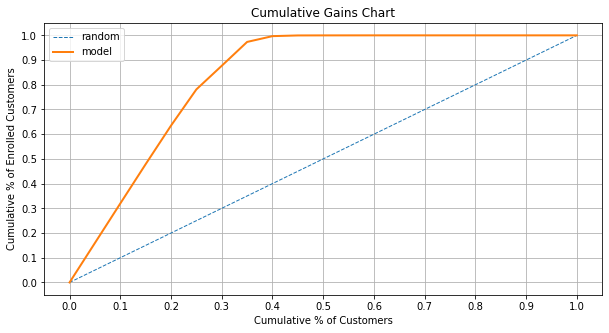

In [26]:
# show a cumulative gains chart
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random', linestyle='--', linewidth=1)

# we add an element to the start of each series for 0%
plt.plot(pd.concat([pd.Series([0]), df_lift_gains_summary['Cumulative % of Customers']]), pd.concat([pd.Series([0]), df_lift_gains_summary['Cumulative % of Enrolled Customers']]), label='model', linewidth=2)

plt.xlabel('Cumulative % of Customers')
plt.ylabel('Cumulative % of Enrolled Customers')
plt.title('Cumulative Gains Chart')
plt.legend(loc='best')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid()

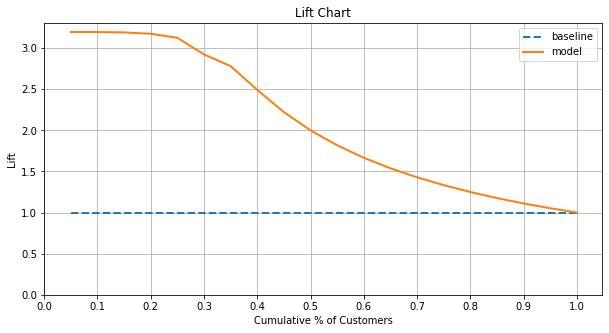

In [27]:
# show the lift chart
fig = plt.figure(figsize=(10,5))
plt.plot([0.05, 1], [1, 1], label='baseline', linestyle='--', linewidth=2)

plt.plot(df_lift_gains_summary['Cumulative % of Customers'], df_lift_gains_summary['Lift'], label='model', linewidth=2)

plt.xlabel('Cumulative % of Customers')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc='best')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.ylim(bottom=0)
plt.grid()

### Feature Importance

Finally we'll look at feature importance for the selected model. The table indicates, at the feature level, some importance for the variable in classifying the outcome variable. Energy usage and efficiency along with customer lifetime value are important features in predicting who will enroll in the program.

In [28]:
l_cat_dummies = top_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names(input_features=l_cat_cols)

feature_list = l_numerical_features.copy()
feature_list.extend(l_bool_cols)
feature_list.extend(l_cat_dummies)

feature_imp=eli5.explain_weights_df(top_pipeline.named_steps['classifier'],feature_names=feature_list)
eli5.explain_weights(top_pipeline.named_steps['classifier'],feature_names=feature_list, top=100)

Weight,Feature
0.1069 ± 0.0317,ENERGY_EFFICIENCY
0.0938 ± 0.0235,CLTV
0.0832 ± 0.0295,ENERGY_USAGE_PER_MONTH
0.0761 ± 0.0307,HOME_SIZE
0.0713 ± 0.0363,IS_REGISTERED_FOR_ALERTS
0.0707 ± 0.0078,AGE
0.0565 ± 0.0221,OWNS_HOME
0.0483 ± 0.0367,HAS_HOME_AUTOMATION
0.0397 ± 0.0058,STD_YRLY_USAGE_CUR_YEAR_MINUS_1
0.0381 ± 0.0263,HAS_THERMOSTAT


### Save Data for RShiny Dashboard

We save the data out for use in the RShiny dashboard. We will combine the raw training data with actual and predicted probabilities and display these model insights on the dashboard. We also save out the test data in the same file. For demo purposes, we will not provide the actual target variable for the test data. It will act as new data which has just been scored. We don't yet know if these customers have enrolled in the Demand Response Program. This data can be filtered and exported through the dashboard.

In [29]:
df_act_vs_pred = X_train.copy()
df_act_vs_pred['actual'] = y_train
df_act_vs_pred['predicted_probability'] = y_pred_train
df_act_vs_pred['predicted_class'] = y_pred_class_train
df_act_vs_pred['dataset'] = 'Seen'

df_temp_test = X_test.copy()
df_temp_test['actual'] = np.nan
df_temp_test['predicted_probability'] = y_pred_test
df_temp_test['predicted_class'] = y_pred_class_test
df_temp_test['dataset'] = 'Unseen'

df_act_vs_pred = pd.concat([df_act_vs_pred, df_temp_test],ignore_index=True)

df_act_vs_pred.sort_values(['dataset', 'predicted_probability'], inplace=True, ascending=[True, False])

df_act_vs_pred[l_cat_cols] = df_act_vs_pred[l_cat_cols].fillna('Other')

project.save_data('model output summary.csv', df_act_vs_pred.to_csv(index=False), overwrite=True)

{'file_name': 'model output summary.csv',
 'message': 'File saved to project storage.',
 'asset_id': '0b1ccabd-b01d-40f3-8cca-d6f8181bab1c'}

## Save the Pipeline to Cloud Pak for Data

In the next steps we save and deploy the pipeline. The pipeline can be saved and deployed in the same way we save and deploy models. 

Before we save the pipeline we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.s. 

### User Inputs

The user can specify the names for the space, model and model deployment. The user can specify the name for the space, models and model deployments.  <br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to `True`.

In [30]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Utilities Demand Response Propensity Space'
model_name = 'demand_response_propensity_pipeline'
deployment_name = 'demand_response_propensity_pipeline_deployment'

use_existing_space=True

In [31]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. 

By default, if the space with specified name already exists, the existing space will be used to store and deploy the models.

In [32]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Utilities Demand Response Propensity Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If its not 'active', you can monitor the state with a call to spaces.get_details(space_id)


### Store the Pipeline Details
Store the pipeline in the deployment space. Again, the name for the pipeline is specified in the user inputs cell above.  Software specification and default tag for the model are specified in the model metadata. <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [33]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.TAGS: ['utilities_demand_response_propensity_pipeline_tag']
}

stored_model_details = client.repository.store_model(model=clf, meta_props=metadata, training_data=X_train, training_target=y_train, feature_names=X_train.columns)
stored_model_details




{'entity': {'label_column': 'DEMAND_RESPONSE',
  'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'CUSTOMER_ID', 'type': 'int64'},
      {'name': 'FIRST_NAME', 'type': 'object'},
      {'name': 'LAST_NAME', 'type': 'object'},
      {'name': 'PHONE_1', 'type': 'object'},
      {'name': 'EMAIL', 'type': 'object'},
      {'name': 'AGE', 'type': 'int64'},
      {'name': 'HOME_SIZE', 'type': 'int64'},
      {'name': 'ENERGY_USAGE_PER_MONTH', 'type': 'int64'},
      {'name': 'ENERGY_EFFICIENCY', 'type': 'float64'},
      {'name': 'IS_REGISTERED_FOR_ALERTS', 'type': 'int64'},
      {'name': 'OWNS_HOME', 'type': 'int64'},
      {'name': 'COMPLAINTS', 'type': 'int64'},
      {'name': 'EST_INCOME', 'type': 'int64'},
    

### Deploy the Model Pipeline

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

We also create a dictionary with model metadata here.  We save the dictionary with column names and categories to be grouped and also save out the threshold value calculated above. We save the dictionary as part of the metadata, in `client.deployments.ConfigurationMetaNames.CUSTOM`, when deploying the pipeline. It gets deployed with the pipeline and can be retrieved in the deployed function, as demonstrated in the **2-model_scoring_and_app_deployment** notebook.

In [34]:
#Save metadata
metadata_dict = {'grouping_cols' : grouping_dict, 'probability_threshold' : opt_threshold.astype(float)}

In [35]:
# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [ 'utilities_demand_response_propensity_pipeline_deployment_tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: metadata_dict
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create( artifact_uid=model_uid, meta_props=meta_props)





#######################################################################################

Synchronous deployment creation for uid: '399a5012-2227-4546-bbab-3678b6c19eb0' started

#######################################################################################


initializing.......................................................................................................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ec1d5fd6-db88-42f3-918f-0f1f8cba08ed'
------------------------------------------------------------------------------------------------




### Operationalize the models
Now we are ready to operationalize our pipeline. See notebook **2-model_scoring_and_app_deployment** for the next step.